In [1]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#

In [2]:
model = maskrcnn_resnet50_fpn(
  weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.COCO_V1
)
model.eval()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
from torchinfo import summary

summary(
  model,
  input_size=(1, 3, 800, 800),
  device=device.type,
)  # input: (batch_size, channels, height, width)

Layer (type:depth-idx)                                  Output Shape              Param #
MaskRCNN                                                [0, 4]                    --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

Image shape: torch.Size([1, 3, 500, 381])


C:\Users\Plancha\AppData\Local\Temp\ipykernel_34688\4046294543.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(mask_list))


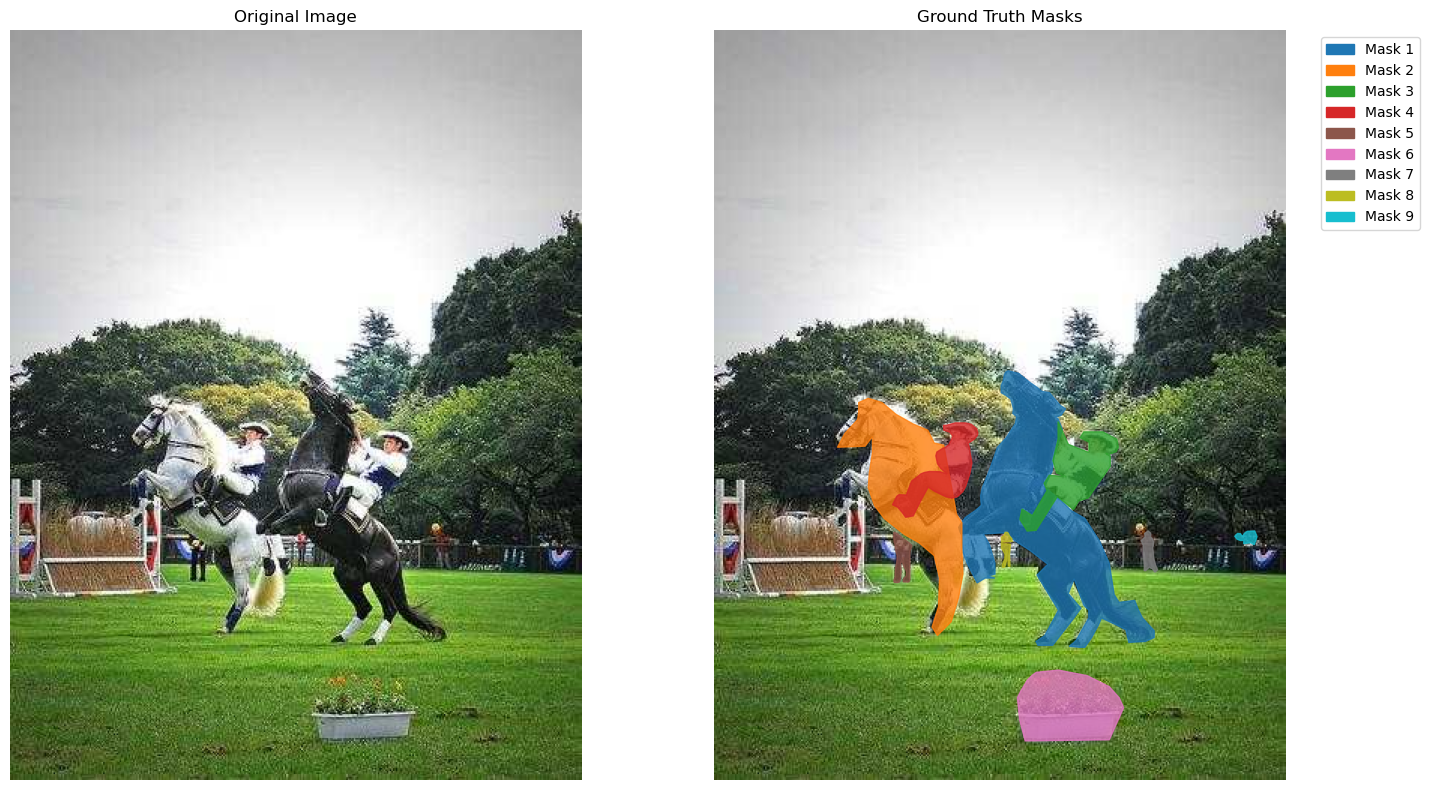

In [9]:
# download https://github.com/ultralytics/assets/releases/download/v0.0.0/coco8-seg.zip and save it to data/coco8-seg
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import os
from pyprojroot import here
from matplotlib.patches import Patch


def download_and_unzip(url, extract_to="."):
  http_response = urlopen(url)
  zipfile = ZipFile(BytesIO(http_response.read()))
  zipfile.extractall(path=extract_to)


def load_image(image_path):
  image = Image.open(image_path).convert("RGB")
  image_tensor = F.to_tensor(image).unsqueeze(0)  # Add batch dimension
  return image_tensor


if not os.path.exists(here("data/coco8-seg/images/train")):
  download_and_unzip(
    r"https://github.com/ultralytics/assets/releases/download/v0.0.0/coco8-seg.zip",
    extract_to=here("data/coco8-seg"),
  )

image_path = here(r"data\coco8-seg\coco8-seg\images\val\000000000049.jpg")
labels_path = here(r"data\coco8-seg\coco8-seg\labels\val\000000000049.txt")

image_tensor = load_image(image_path)
image_tensor = image_tensor.to(device)
print(f"Image shape: {image_tensor.shape}")  # Should be (1, 3, H, W) after unsqueeze

# Parse YOLO segmentation masks from label file
mask_list = []
img_w, img_h = Image.open(image_path).size
with open(labels_path, "r") as f:
  for line in f:
    parts = line.strip().split()
    # YOLO format: class cx cy x1 y1 x2 y2 ... (all normalized)
    coords = list(map(float, parts[1:]))
    # Convert normalized coordinates to pixel coordinates
    xy = np.array(coords).reshape(-1, 2)
    xy[:, 0] *= img_w
    xy[:, 1] *= img_h
    mask_list.append(xy)

# Show original image side by side with ground truth masks
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Load the image as a PIL Image object
image = Image.open(image_path).convert("RGB")

# Show original image
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")

# Show ground truth masks
axs[1].imshow(image)
colors = plt.cm.get_cmap("tab10", len(mask_list))
legend_patches = []
for idx, mask in enumerate(mask_list):
  axs[1].fill(mask[:, 0], mask[:, 1], alpha=0.8, color=colors(idx))
  legend_patches.append(Patch(color=colors(idx), label=f"Mask {idx + 1}"))
axs[1].set_title("Ground Truth Masks")
axs[1].axis("off")
if legend_patches:
  axs[1].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

C:\Users\Plancha\AppData\Local\Temp\ipykernel_34688\2911737617.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gt_colors = plt.cm.get_cmap('tab10', num_gt)
C:\Users\Plancha\AppData\Local\Temp\ipykernel_34688\2911737617.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_colors)


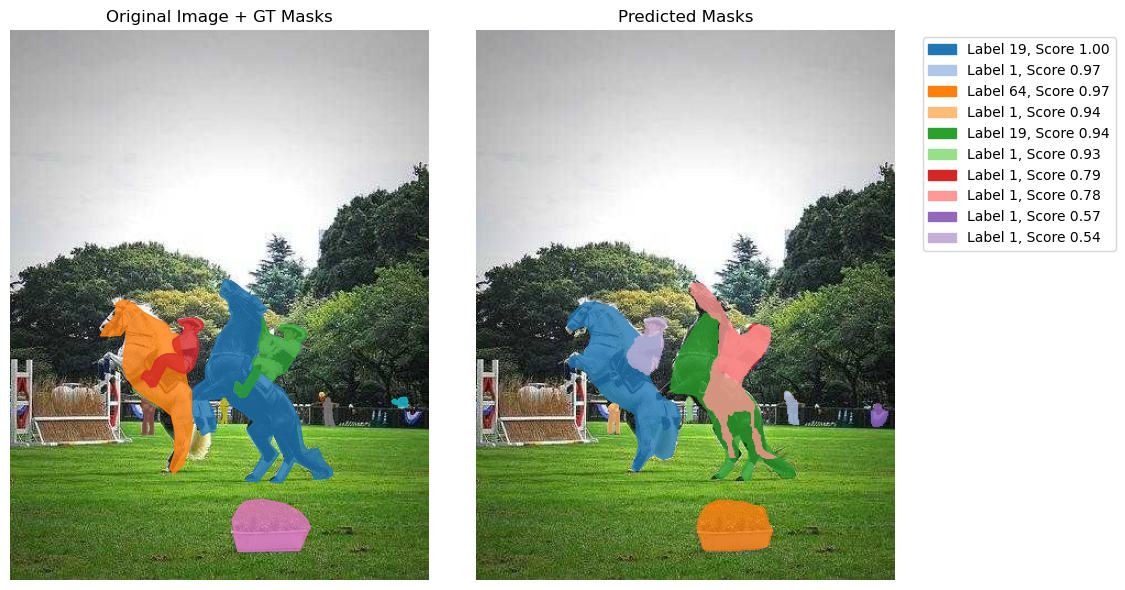

In [11]:
model.eval()

with torch.no_grad():
  predictions = model(image_tensor)


def plot_masks_with_gt(image_path, predictions, mask_list, threshold=0.5):
  image = Image.open(image_path).convert("RGB")
  masks = predictions[0]["masks"].cpu().numpy()
  scores = predictions[0]["scores"].cpu().numpy()
  labels = predictions[0]["labels"].cpu().numpy()

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Show original image with ground truth masks (each with a different color)
  axs[0].imshow(image)
  num_gt = len(mask_list)
  gt_colors = plt.cm.get_cmap("tab10", num_gt)
  for idx, mask in enumerate(mask_list):
    axs[0].fill(
      mask[:, 0], mask[:, 1], alpha=0.8, color=gt_colors(idx), edgecolor=gt_colors(idx)
    )
  axs[0].set_title("Original Image + GT Masks")
  axs[0].axis("off")

  # Show image with predicted masks
  axs[1].imshow(image)
  num_colors = min(masks.shape[0], 20)
  colors = plt.cm.get_cmap("tab20", num_colors)
  legend_patches = []

  for idx, (mask, score, label) in enumerate(zip(masks, scores, labels)):
    if score < threshold:
      continue
    mask = mask[0]
    mask_bin = np.where(mask > 0.5, 1, 0)
    color = colors(idx % num_colors)
    colored_mask = np.zeros((*mask_bin.shape, 4))
    colored_mask[..., :3] = color[:3]
    colored_mask[..., 3] = mask_bin * 0.8
    axs[1].imshow(colored_mask)
    legend_patches.append(Patch(color=color, label=f"Label {label}, Score {score:.2f}"))

  axs[1].set_title("Predicted Masks")
  axs[1].axis("off")
  if legend_patches:
    axs[1].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left")
  plt.tight_layout()
  plt.show()


plot_masks_with_gt(image_path, predictions, mask_list, threshold=0.5)

C:\Users\Plancha\AppData\Local\Temp\ipykernel_34688\4206234734.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gt_colors = plt.cm.get_cmap('tab10', num_gt)


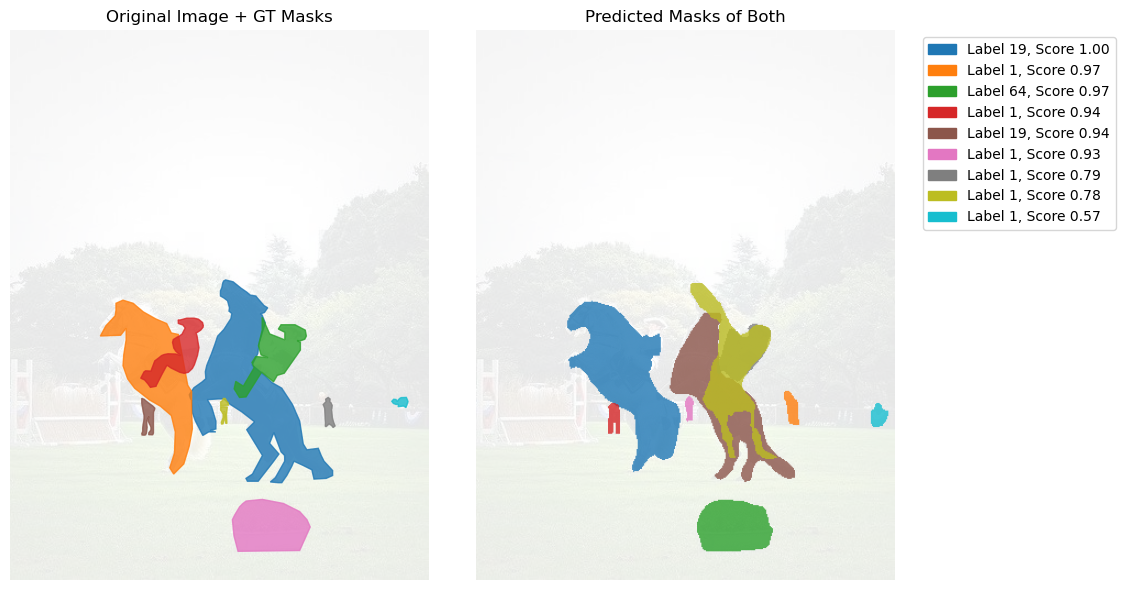

In [30]:
# paint only the masks of both
def plot_masks_of_both(image_path, predictions, mask_list, threshold=0.5):
  image = Image.open(image_path).convert("RGBA")  # Add alpha channel
  masks = predictions[0]["masks"].cpu().numpy()
  scores = predictions[0]["scores"].cpu().numpy()
  labels = predictions[0]["labels"].cpu().numpy()

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Show original image with ground truth masks (each with a different color)
  axs[0].imshow(image, alpha=0.1)
  num_gt = len(mask_list)
  gt_colors = plt.cm.get_cmap("tab10", num_gt)
  for idx, mask in enumerate(mask_list):
    axs[0].fill(
      mask[:, 0], mask[:, 1], alpha=0.8, color=gt_colors(idx), edgecolor=gt_colors(idx)
    )
  axs[0].set_title("Original Image + GT Masks")
  axs[0].axis("off")

  # Show image with predicted masks, using the same palette as the left
  axs[1].imshow(image, alpha=0.1)
  legend_patches = []

  color_idx = 0
  for idx, (mask, score, label) in enumerate(zip(masks, scores, labels)):
    if score < threshold or color_idx >= num_gt:
      continue
    mask = mask[0]
    mask_bin = np.where(mask > 0.5, 1, 0)
    color = gt_colors(color_idx)
    colored_mask = np.zeros((*mask_bin.shape, 4))
    colored_mask[..., :3] = color[:3]
    colored_mask[..., 3] = mask_bin * 0.8
    axs[1].imshow(colored_mask)
    legend_patches.append(Patch(color=color, label=f"Label {label}, Score {score:.2f}"))
    color_idx += 1

  axs[1].set_title("Predicted Masks of Both")
  axs[1].axis("off")
  if legend_patches:
    axs[1].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left")

  plt.tight_layout()
  plt.show()


plot_masks_of_both(image_path, predictions, mask_list, threshold=0.5)